In [2]:
%matplotlib inline
import sys
sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover, FixedIlluminationMover
from weak_sauce.fit_flat import FlatFitter

def gauss(centroids, mu=np.array([0, 0]), sigma=np.array([1., 1.])):
    return np.exp(-0.5 * np.sum(np.square((centroids - mu) / sigma), axis=2)) / \
           (2 * np.pi * np.prod(sigma))

To assess the science impact of pixel size variation in LSST sensors, we will need to lay down sources with the following varying properties:
* focal plane position ( x in [50,3950]; y in [50,3950] with half-pixel step size 
* ellipticity of source ( e in [0,1])
* orientation of source (theta in [0,180 degrees])

Steps (first over small section of chip):
1. Fit a model to an LSST ultraflat
2. For src_prop in {above}: lay down a source on the fitted model
3. Use moments code to record "observed" moments.

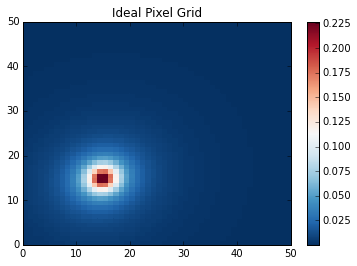

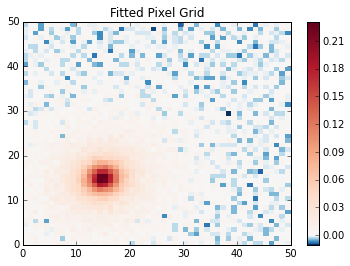

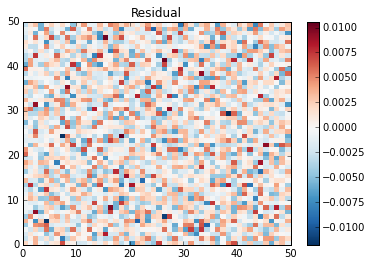

In [13]:
from weak_sauce.adaptive_moments.psf_evaluator import Moment_Evaluator

temp = MoveableGrid('../data/test100k_iter.pkl')
flat=np.load('../data/data_rel_flux_map_50x50.npy')
n_verts_x = 51

import galsim
obj = galsim.Sersic(4,half_light_radius=10) #deV profile
obj = obj.shear(e=.1,beta=galsim.Angle(45,galsim.degrees))
psf = galsim.Moffat(4.765,fwhm=3)
obj = galsim.Convolve(obj,psf)
obj = obj.shift(15,15)

stationary_source = Source(num_x=5*(n_verts_x-1)+1, min_x=0, max_x=50, flux_func=obj)
illuminator = FixedIlluminationMover(stationary_source)

ideal_grid = Source(num_x=n_verts_x)
ideal_mg = MoveableGrid(ideal_grid,illuminator)
ideal_mg.step()
ideal_mg.plot_real_grid()
plt.title('Ideal Pixel Grid')

temp.source.fluxes -= 1
temp.source.psf_evaluator = Moment_Evaluator(num_iter_max = 1000)
mg = MoveableGrid(temp.source, illuminator)
mg.step()
mg.source.fluxes /= flat
mg.plot_real_grid()
plt.title('Fitted Pixel Grid')

mg.source.plot(mg.source.fluxes-ideal_mg.source.fluxes)
plt.title('Residual')

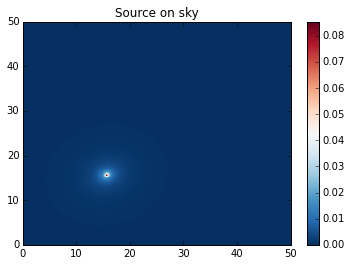

In [11]:
stationary_source.plot(stationary_source.fluxes,
                           stationary_source.vertices[:,:,0],
                           stationary_source.vertices[:,:,1],
                           pcolormesh_kwargs_in={'linewidths':0})
plt.title('Source on sky')

In [169]:
#temp.source.psf_evaluator = Moment_Evaluator(num_iter_max = 1000000, bound_correct_wt = 0.25, epsilon=1e-10)
mg.evaluate_psf()

,Mx,Mxx,Mxy,My,Myy,a4,delta1,delta2,e0,e0prime,e1,e2,flux,fwhm,phi,w,w1,w2,wd1,wd2,
0,14.499588,9.07437,-0.000875,14.500417,9.082444,0.000148,0.00003,-0.000072,0.661816,1.323632,-0.000294,-0.000064,37.497696,3.013039,-1.464093,0.017353,0.001848,-0.017254,0.039455,-0.016234,...


In [170]:
ideal_mg.evaluate_psf()

,Mx,Mxx,Mxy,My,Myy,a4,delta1,delta2,e0,e0prime,e1,e2,flux,fwhm,phi,w,w1,w2,wd1,wd2,
0,14.5,9.080231,1.620153e-10,14.5,9.080231,-0.000006,-6.084949e-10,8.451364e-10,0.661949,1.323898,-5.262044e-10,1.181090e-11,37.500239,3.013342,1.559575,0.000023,0,0.000023,0.000754,0.000677,...


In [6]:
import pandas as pd
import copy
res_df = pd.DataFrame()
ideal_df = pd.DataFrame()
n_verts_x = 51
saved_mg = MoveableGrid('test100k_iter.pkl')
flat=np.load('data_rel_flux_map_50x50.npy')

for xctr in np.arange(15,36):
    for yctr in np.arange(15,36):
        temp = copy.deepcopy(saved_mg)
        #source should be oversampled wrt pixels; hence the 5x
        stationary_source = Source(num_x=5*(n_verts_x-1)+1, min_x=0, max_x=50, \
                                   flux_func=gauss, mu=(xctr,yctr),sigma=3)
        #stationary_source = Source(num_x=n_verts_x, flux_func=gauss, mu=(xctr,yctr),sigma=3) #non-oversampled
        illuminator = FixedIlluminationMover(stationary_source)

        ideal_grid = Source(num_x=n_verts_x)
        ideal_mg = MoveableGrid(ideal_grid,illuminator)
        ideal_mg.step()
        ideal_res = ideal_mg.evaluate_psf()
        ideal_df = ideal_df.append(ideal_res)
        
        temp.source.fluxes -= 1
        temp.source.psf_evaluator = Moment_Evaluator(num_iter_max = 1000)
        mg = MoveableGrid(temp.source, illuminator)
        mg.step()
        mg.source.fluxes /= flat
        fitted_res = mg.evaluate_psf()
        res_df = res_df.append(fitted_res)

In [189]:
res_df

,Mx,Mxx,Mxy,My,Myy,a4,delta1,delta2,e0,e0prime,e1,e2,flux,fwhm,phi,w,w1,w2,wd1,wd2,
0,14.499588,9.074370,-0.000875,14.500417,9.082444,0.000148,0.000030,-0.000072,0.661816,1.323632,-0.000294,-0.000064,37.497696,3.013039,-1.464093,0.017353,0.001848,-0.017254,0.039455,-0.016234,...
0,15.499257,9.077570,-0.002076,14.500295,9.082671,0.000021,0.000100,-0.000059,0.661941,1.323882,-0.000186,-0.000151,37.499827,3.013324,-1.229137,0.015483,0.005188,-0.014589,0.048063,-0.008606,...
0,14.499543,9.073551,-0.000007,15.500426,9.080271,0.000238,-0.000042,0.000005,0.661707,1.323414,-0.000245,-0.000001,37.495648,3.012791,-1.569734,0.015651,0.000017,-0.015651,0.018685,0.029530,...
0,15.499140,9.076939,-0.000761,15.500396,9.081459,0.000054,0.000007,0.000003,0.661874,1.323747,-0.000165,-0.000055,37.498711,3.013171,-1.408480,0.013184,0.002131,-0.013011,0.019831,0.002413,...


In [7]:
resid_df = res_df-ideal_df

In [9]:
resid_df2 = resid_df[resid_df['Mx']<.3]
resid_df2.describe()
resid_df = resid_df2

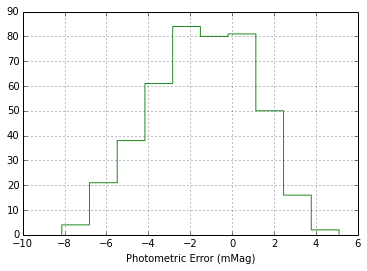

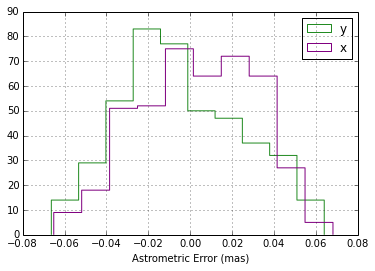

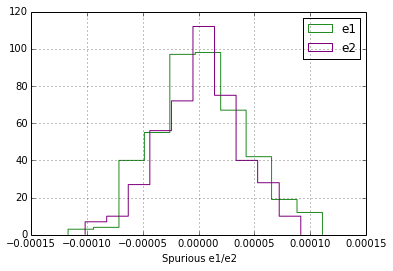

In [10]:
(resid_df['flux']/(.001*np.log(10)/2.5)).hist(bins=10,histtype='step',color='ForestGreen') #convert %flux to mMag
plt.xlabel('Photometric Error (mMag)')
plt.figure()
(200*resid_df['Mx']).hist(bins=10,histtype='step',color='ForestGreen',label='y') #LSST pixel size
(200*resid_df['My']).hist(bins=10,histtype='step',color='Purple',label='x')
plt.legend()
plt.xlabel('Astrometric Error (mas)')
plt.figure()
(.2**2/.27**2*resid_df['e1']).hist(bins=10,histtype='step',color='ForestGreen',label='e1') #convert to LSST pixels
(.2**2/.27**2*resid_df['e2']).hist(bins=10,histtype='step',color='Purple',label='e2')
plt.legend()
plt.xlabel('Spurious e1/e2')

##Features to add (without reinventing the Galsim wheel too much):
side note: import stuff from galsim?

1. need to vary flux over some interesting range
2. figure out what covariance matrices correspond to ellipticity .1, .2, etc.
3. speed up code for larger-scale run.
4. Whisker maps of distortions


(13, 35)

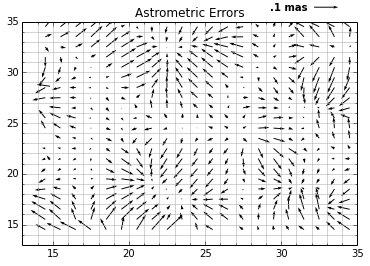

In [39]:
Q = plt.quiver(ideal_df['Mx'],ideal_df['My'],resid_df['Mx'],resid_df['My'])
qk = plt.quiverkey(Q, 0.8, 0.95, .0005, '.1 mas',
               labelpos='W',
               coordinates='figure',
               fontproperties={'weight': 'bold'})
plt.title('Astrometric Errors')
plt.grid(b=True, which='major', color='DarkGray', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='DarkGray', linestyle='-')
plt.xlim(13,35)
plt.ylim(13,35)

##More advanced assessment with GalSim